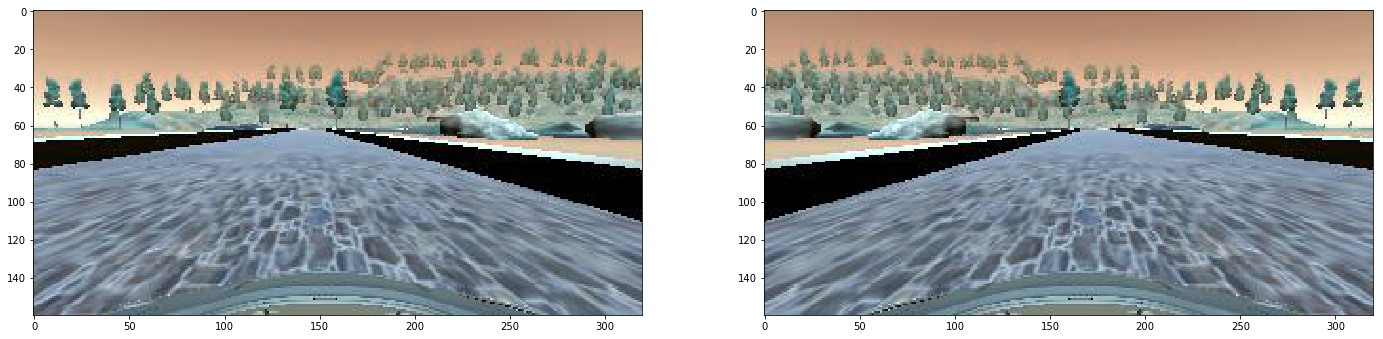

In [3]:
#importing all necessary modules
import os
import csv
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from random import shuffle
from sklearn.model_selection import train_test_split

CORRECTION = 0.2

#show example of flipped image
img = cv2.imread('data/IMG/center_2016_12_01_13_32_48_402.jpg')
augmented_image = cv2.flip(img,1)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(augmented_image)



In [4]:

#use generator to pass training samples
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image_name = 'data/IMG/'+batch_sample[0].split('/')[-1]
                left_image_name = 'data/IMG/'+batch_sample[1].split('/')[-1]
                right_image_name = 'data/IMG/'+batch_sample[2].split('/')[-1]
                center_image = cv2.imread(center_image_name)
                left_image = cv2.imread(left_image_name)
                right_image = cv2.imread(right_image_name)
                #rearrange the dimensions
                center_angle = float(batch_sample[3])
                left_angle = center_angle + CORRECTION
                right_angle = center_angle - CORRECTION
                images.extend([center_image, left_image, right_image])
                angles.extend([center_angle, left_angle, right_angle])
            #augment image
            augmented_images, augmented_angles = [], []
            for image, angle in zip(images, angles):
                augmented_images.append(image)
                augmented_images.append(cv2.flip(image,1))
                augmented_angles.append(angle)
                augmented_angles.append(angle*-1.0)
            # trim image to only see section with road
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

samples = []
training_file = 'data/driving_log.csv'
with open(training_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

#build model
model = Sequential()
#normalizing
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
#cropping
model.add(Cropping2D(cropping=((70,25), (0,0))))
#network
model.add(Convolution2D(6,5,5, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))
#add dropout?
# model.add(Dropout())

model.compile(loss='mse', optimizer='adam')

#save history
history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch = len(train_samples), 
                                     validation_data = validation_generator,
                                     nb_val_samples = len(validation_samples),
                                     nb_epoch=5, verbose=1)

#save the model
model.save('model.h5')



Epoch 1/5
6336/6428 [============================>.] - ETA: 0s - loss: 0.3378

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6528/6428 [==============================] - 10s - loss: 0.3290 - val_loss: 0.0416
Epoch 2/5
6528/6428 [==============================] - 7s - loss: 0.0364 - val_loss: 0.0297
Epoch 3/5
6528/6428 [==============================] - 7s - loss: 0.0258 - val_loss: 0.0295
Epoch 4/5
6528/6428 [==============================] - 7s - loss: 0.0241 - val_loss: 0.0230
Epoch 5/5
6528/6428 [==============================] - 7s - loss: 0.0246 - val_loss: 0.0244


dict_keys(['loss', 'val_loss'])


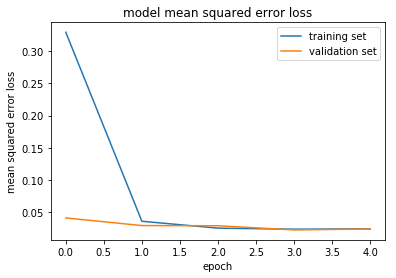

In [5]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
